#  Recomendador basado en factorización matricial

Para la realización de este estudio comparativo se ha empleado la información del blog: https://r-bloggers.com/2015/03/matrix-factorization/ y los datos proporcionados en: https://files.grouplens.org/datasets/movielens/ .

Se usa la librería surprise la cual necesita un Kernel de Python 3.10.

In [9]:
%pip install pandas numpy scikit-surprise matplotlib scikit-learn scipy surprise

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from math import sqrt
from scipy.optimize import minimize

from sklearn.metrics import roc_curve, auc, mean_squared_error

from surprise import Dataset, Reader, NormalPredictor, KNNBasic, SVD, AlgoBase, accuracy, PredictionImpossible
from surprise.model_selection import train_test_split, KFold

GLOBAL_RANDOM = 42
GLOBAL_RATING_THRESHOLD = 3.5

np.random.seed(GLOBAL_RANDOM)

Realizamos las pruebas sobre los datos con 1 millón de entradas. Hemos probado a hacerlas con los datos de 10 millones pero aún con 32GB de RAM no es suficiente para llevarlo a cabo.

In [2]:
movies_df = pd.read_csv(
    './ml-1m/movies.dat',
    sep='::',                  # Especificar el delimitador '::'
    engine='python',           # Especificar el motor de Python para manejar delimitadores complejos
    names=['movieId', 'title', 'genres'],  # Nombres de las columnas
    encoding='utf-8'           # Ajustar la codificación si es necesario
)
ratings_df = pd.read_csv(
    './ml-1m/ratings.dat',
    sep='::',                  # Especificar el delimitador '::'
    engine='python',           # Especificar el motor de Python para manejar delimitadores complejos
    names=['userId', 'movieId', 'rating', 'timestamp'],  # Nombres de las columnas
    encoding='utf-8'           # Ajustar la codificación si es necesario
)

Aqui creamos una clase para el recomendador por popularidad ya que no estaba implementado en ninguna de las librerías empleadas. Hace un simple ranking por el promedio de las puntuaciones de cada película.

In [3]:
class PopularRecommender(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        ratings = defaultdict(list)
        for (uid, iid, rating) in trainset.all_ratings():
            ratings[iid].append(rating)
        self.avg_rating = {trainset.to_raw_iid(i): np.mean(ratings[i]) for i in ratings}
        return self

    def estimate(self, u, i):
        try:
            if self.trainset.knows_item(i):
                return self.avg_rating[self.trainset.to_raw_iid(i)]
            else:
                raise PredictionImpossible('Item not in training data')
        except KeyError:
            return self.trainset.global_mean

Creamos una lista con los modelos para facilitar su estudio

In [4]:
# Creación de los modelos
models = {
    "Random": NormalPredictor(),
    "Popular": PopularRecommender(),  # Asegúrate de que esta clase esté definida como mostré anteriormente
    "User-Based CF": KNNBasic(sim_options={'user_based': True}),
    "Item-Based CF": KNNBasic(sim_options={'user_based': False}),
    "Matrix Factorization": SVD(random_state=GLOBAL_RANDOM)
}

Empleamos el ejemplo proporcionado por la librería surprise para crear una funcion que evalue el recall y la precision de las predicciones proporcionadas: https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py 


In [5]:
def precision_recall_at_k(predictions, k=10, threshold=GLOBAL_RATING_THRESHOLD):
    """Devuelve las métricas de precisión y recall en k para cada usuario"""

    # Primero mapeamos las predicciones a cada usuario.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Ordenamos las calificaciones del usuario por el valor estimado
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Número de ítems relevantes
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Número de ítems recomendados en el top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Número de ítems relevantes y recomendados en el top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precisión@K: Proporción de ítems recomendados que son relevantes
        # Cuando n_rec_k es 0, la precisión es indefinida. Aquí lo establecemos a 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proporción de ítems relevantes que son recomendados
        # Cuando n_rel es 0, el recall es indefinido. Aquí lo establecemos a 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

Para cada modelo se hace una validación cruzada en ksplits (en este caso 5) que despues se usa para imprimir tanto la grafica Recall vs Precision como la curva ROC y el RMSE (Raíz del Error Cuadrático Medio)

RMSE: 1.5156
RMSE: 0.9824
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9258
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9180
RMSE: 0.8785
RMSE: 1.5090
RMSE: 0.9772
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9211
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9121
RMSE: 0.8729
RMSE: 1.5154
RMSE: 0.9774
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9208
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9128
RMSE: 0.8710
RMSE: 1.5148
RMSE: 0.9798
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9233
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9146
RMSE: 0.8731
RMSE: 1.5124
RMSE: 0.9801
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9231
Computing the msd similarity matrix...
Done 

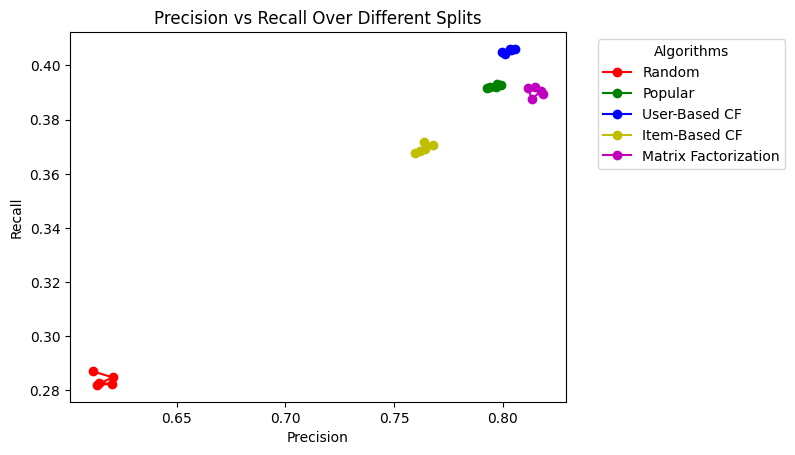

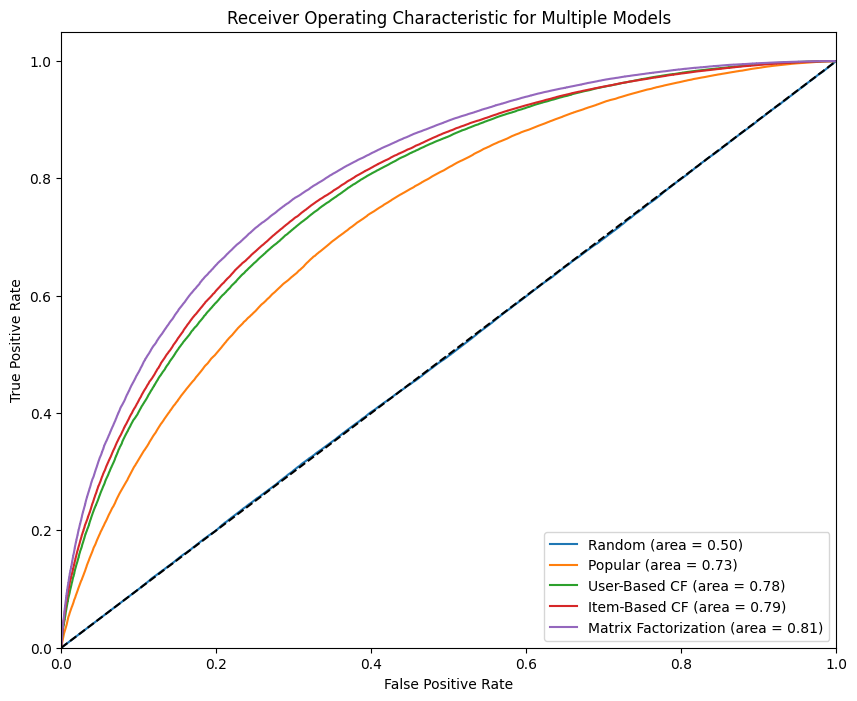

RMSE - Random: 1.51238224972204
RMSE - Popular: 0.9801152379579265
RMSE - User-Based CF: 0.9231167505746659
RMSE - Item-Based CF: 0.9144264282222703
RMSE - Matrix Factorization: 0.8730224235895983


In [6]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
ksplits = 5

# Preparamos la evaluación cruzada
kf = KFold(n_splits=ksplits)
precision_recall_results = defaultdict(list)
roc_results = {}
rmse_results = {}

# Ejecutamos la evaluación cruzada para todos los algoritmos
for i, (trainset, testset) in enumerate(kf.split(data)):
    for name, model in models.items():
        # Entrenamiento y predicción con cada modelo
        model.fit(trainset)
        predictions = model.test(testset)
        
        # Calculamos para curvas de precisión y recall
        precisions, recalls = precision_recall_at_k(predictions, ksplits)
        mean_prec = np.mean(list(precisions.values()))
        mean_rec = np.mean(list(recalls.values()))
        precision_recall_results[name].append((mean_prec, mean_rec))
        
        # Preparamos los datos para la curva ROC
        y_real = np.array([pred.r_ui for pred in predictions])
        y_scores = np.array([pred.est for pred in predictions])
        y_real_binary = (y_real >= GLOBAL_RATING_THRESHOLD).astype(int)
        fpr, tpr, _ = roc_curve(y_real_binary, y_scores)
        roc_auc = auc(fpr, tpr)
        roc_results[name] = (fpr, tpr, roc_auc)
        
        # Calculamos el RMSE
        rmse_results[name] = accuracy.rmse(predictions)

# Visualizamos los resultados de precisión y recall
fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm']  # Colores para los diferentes algoritmos
for name, points in precision_recall_results.items():
    if points:
        xs, ys = zip(*points) if len(points) > 1 else ([points[0][0]], [points[0][1]])
        ax.plot(xs, ys, marker='o', linestyle='-', color=colors.pop(0), label=name)

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision vs Recall Over Different Splits')
ax.legend(title="Algorithms", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualizamos las curvas ROC para cada modelo
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiple Models')
plt.legend(loc="lower right")
plt.show()

# Imprimimos los resultados de RMSE
for name, rmse_value in rmse_results.items():
    print(f"RMSE - {name}: {rmse_value}")

Podemos ver que el metodo matricial proporciona mejor Precision, área bajo la curva ROC y RMSE, aunque el basado en usuarios presenta mejor Recall.